# `pathlib` --- Object-oriented filesystem paths

pathlib

3.4

**Source code:** `Lib/pathlib.py`

single: path; operations

------------------------------------------------------------------------

This module offers classes representing filesystem paths with semantics
appropriate for different operating systems. Path classes are divided
between `pure paths <pure-paths>`, which provide purely computational
operations without I/O, and `concrete paths <concrete-paths>`, which
inherit from pure paths but also provide I/O operations.

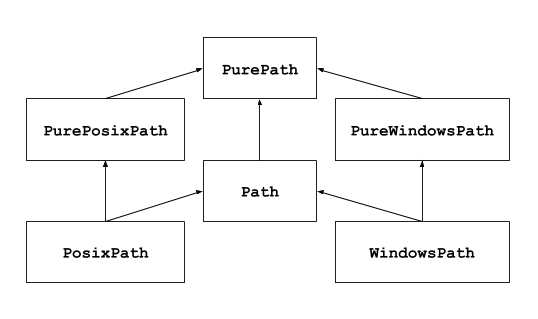

If you've never used this module before or just aren't sure which class
is right for your task, `Path` is most likely what you need. It
instantiates a `concrete path <concrete-paths>` for the platform the
code is running on.

Pure paths are useful in some special cases; for example:

1.  If you want to manipulate Windows paths on a Unix machine (or vice
    versa). You cannot instantiate a `WindowsPath` when running on Unix,
    but you can instantiate `PureWindowsPath`.
2.  You want to make sure that your code only manipulates paths without
    actually accessing the OS. In this case, instantiating one of the
    pure classes may be useful since those simply don't have any
    OS-accessing operations.

`428`: The pathlib module -- object-oriented filesystem paths.

For low-level path manipulation on strings, you can also use the
`os.path` module.

## Basic use

Importing the main class:

    >>> from pathlib import Path

Listing subdirectories:

    >>> p = Path('.')
    >>> [x for x in p.iterdir() if x.is_dir()]
    [PosixPath('.hg'), PosixPath('docs'), PosixPath('dist'),
     PosixPath('__pycache__'), PosixPath('build')]

Listing Python source files in this directory tree:

    >>> list(p.glob('**/*.py'))
    [PosixPath('test_pathlib.py'), PosixPath('setup.py'),
     PosixPath('pathlib.py'), PosixPath('docs/conf.py'),
     PosixPath('build/lib/pathlib.py')]

Navigating inside a directory tree:

    >>> p = Path('/etc')
    >>> q = p / 'init.d' / 'reboot'
    >>> q
    PosixPath('/etc/init.d/reboot')
    >>> q.resolve()
    PosixPath('/etc/rc.d/init.d/halt')

Querying path properties:

    >>> q.exists()
    True
    >>> q.is_dir()
    False

Opening a file:

    >>> with q.open() as f: f.readline()
    ...
    '#!/bin/bash\n'

## Pure paths

Pure path objects provide path-handling operations which don't actually
access a filesystem. There are three ways to access these classes, which
we also call *flavours*:

A generic class that represents the system's path flavour (instantiating
it creates either a `PurePosixPath` or a `PureWindowsPath`):

    >>> PurePath('setup.py')      # Running on a Unix machine
    PurePosixPath('setup.py')

Each element of *pathsegments* can be either a string representing a
path segment, an object implementing the `os.PathLike` interface which
returns a string, or another path object:

    >>> PurePath('foo', 'some/path', 'bar')
    PurePosixPath('foo/some/path/bar')
    >>> PurePath(Path('foo'), Path('bar'))
    PurePosixPath('foo/bar')

When *pathsegments* is empty, the current directory is assumed:

    >>> PurePath()
    PurePosixPath('.')

When several absolute paths are given, the last is taken as an anchor
(mimicking `os.path.join`'s behaviour):

    >>> PurePath('/etc', '/usr', 'lib64')
    PurePosixPath('/usr/lib64')
    >>> PureWindowsPath('c:/Windows', 'd:bar')
    PureWindowsPath('d:bar')

However, in a Windows path, changing the local root doesn't discard the
previous drive setting:

    >>> PureWindowsPath('c:/Windows', '/Program Files')
    PureWindowsPath('c:/Program Files')

Spurious slashes and single dots are collapsed, but double dots (`'..'`)
are not, since this would change the meaning of a path in the face of
symbolic links:

    >>> PurePath('foo//bar')
    PurePosixPath('foo/bar')
    >>> PurePath('foo/./bar')
    PurePosixPath('foo/bar')
    >>> PurePath('foo/../bar')
    PurePosixPath('foo/../bar')

(a naïve approach would make `PurePosixPath('foo/../bar')` equivalent to
`PurePosixPath('bar')`, which is wrong if `foo` is a symbolic link to
another directory)

Pure path objects implement the `os.PathLike` interface, allowing them
to be used anywhere the interface is accepted.

3.6 Added support for the `os.PathLike` interface.

A subclass of `PurePath`, this path flavour represents non-Windows
filesystem paths:

    >>> PurePosixPath('/etc')
    PurePosixPath('/etc')

*pathsegments* is specified similarly to `PurePath`.

A subclass of `PurePath`, this path flavour represents Windows
filesystem paths:

    >>> PureWindowsPath('c:/Program Files/')
    PureWindowsPath('c:/Program Files')

*pathsegments* is specified similarly to `PurePath`.

Regardless of the system you're running on, you can instantiate all of
these classes, since they don't provide any operation that does system
calls.

### General properties

Paths are immutable and hashable. Paths of a same flavour are comparable
and orderable. These properties respect the flavour's case-folding
semantics:

    >>> PurePosixPath('foo') == PurePosixPath('FOO')
    False
    >>> PureWindowsPath('foo') == PureWindowsPath('FOO')
    True
    >>> PureWindowsPath('FOO') in { PureWindowsPath('foo') }
    True
    >>> PureWindowsPath('C:') < PureWindowsPath('d:')
    True

Paths of a different flavour compare unequal and cannot be ordered:

    >>> PureWindowsPath('foo') == PurePosixPath('foo')
    False
    >>> PureWindowsPath('foo') < PurePosixPath('foo')
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
    TypeError: '<' not supported between instances of 'PureWindowsPath' and 'PurePosixPath'

### Operators

The slash operator helps create child paths, similarly to
`os.path.join`:

    >>> p = PurePath('/etc')
    >>> p
    PurePosixPath('/etc')
    >>> p / 'init.d' / 'apache2'
    PurePosixPath('/etc/init.d/apache2')
    >>> q = PurePath('bin')
    >>> '/usr' / q
    PurePosixPath('/usr/bin')

A path object can be used anywhere an object implementing `os.PathLike`
is accepted:

    >>> import os
    >>> p = PurePath('/etc')
    >>> os.fspath(p)
    '/etc'

The string representation of a path is the raw filesystem path itself
(in native form, e.g. with backslashes under Windows), which you can
pass to any function taking a file path as a string:

    >>> p = PurePath('/etc')
    >>> str(p)
    '/etc'
    >>> p = PureWindowsPath('c:/Program Files')
    >>> str(p)
    'c:\\Program Files'

Similarly, calling `bytes` on a path gives the raw filesystem path as a
bytes object, as encoded by `os.fsencode`:

    >>> bytes(p)
    b'/etc'

Note

Calling `bytes` is only recommended under Unix. Under Windows, the
unicode form is the canonical representation of filesystem paths.

### Accessing individual parts

To access the individual "parts" (components) of a path, use the
following property:

PurePath.parts

A tuple giving access to the path's various components:

    >>> p = PurePath('/usr/bin/python3')
    >>> p.parts
    ('/', 'usr', 'bin', 'python3')

    >>> p = PureWindowsPath('c:/Program Files/PSF')
    >>> p.parts
    ('c:\\', 'Program Files', 'PSF')

(note how the drive and local root are regrouped in a single part)

### Methods and properties

from pathlib import PurePath, PurePosixPath, PureWindowsPath

Pure paths provide the following methods and properties:

PurePath.drive

A string representing the drive letter or name, if any:

    >>> PureWindowsPath('c:/Program Files/').drive
    'c:'
    >>> PureWindowsPath('/Program Files/').drive
    ''
    >>> PurePosixPath('/etc').drive
    ''

UNC shares are also considered drives:

    >>> PureWindowsPath('//host/share/foo.txt').drive
    '\\\\host\\share'

PurePath.root

A string representing the (local or global) root, if any:

    >>> PureWindowsPath('c:/Program Files/').root
    '\\'
    >>> PureWindowsPath('c:Program Files/').root
    ''
    >>> PurePosixPath('/etc').root
    '/'

UNC shares always have a root:

    >>> PureWindowsPath('//host/share').root
    '\\'

PurePath.anchor

The concatenation of the drive and root:

    >>> PureWindowsPath('c:/Program Files/').anchor
    'c:\\'
    >>> PureWindowsPath('c:Program Files/').anchor
    'c:'
    >>> PurePosixPath('/etc').anchor
    '/'
    >>> PureWindowsPath('//host/share').anchor
    '\\\\host\\share\\'

PurePath.parents

An immutable sequence providing access to the logical ancestors of the
path:

    >>> p = PureWindowsPath('c:/foo/bar/setup.py')
    >>> p.parents[0]
    PureWindowsPath('c:/foo/bar')
    >>> p.parents[1]
    PureWindowsPath('c:/foo')
    >>> p.parents[2]
    PureWindowsPath('c:/')

3.10 The parents sequence now supports `slices <slice>` and negative
index values.

PurePath.parent

The logical parent of the path:

    >>> p = PurePosixPath('/a/b/c/d')
    >>> p.parent
    PurePosixPath('/a/b/c')

You cannot go past an anchor, or empty path:

    >>> p = PurePosixPath('/')
    >>> p.parent
    PurePosixPath('/')
    >>> p = PurePosixPath('.')
    >>> p.parent
    PurePosixPath('.')

Note

This is a purely lexical operation, hence the following behaviour:

    >>> p = PurePosixPath('foo/..')
    >>> p.parent

PurePosixPath('foo')

If you want to walk an arbitrary filesystem path upwards, it is
recommended to first call `Path.resolve` so as to resolve symlinks and
eliminate <span class="title-ref">".."</span> components.

PurePath.name

A string representing the final path component, excluding the drive and
root, if any:

    >>> PurePosixPath('my/library/setup.py').name
    'setup.py'

UNC drive names are not considered:

    >>> PureWindowsPath('//some/share/setup.py').name
    'setup.py'
    >>> PureWindowsPath('//some/share').name
    ''

PurePath.suffix

The file extension of the final component, if any:

    >>> PurePosixPath('my/library/setup.py').suffix
    '.py'
    >>> PurePosixPath('my/library.tar.gz').suffix
    '.gz'
    >>> PurePosixPath('my/library').suffix
    ''

PurePath.suffixes

A list of the path's file extensions:

    >>> PurePosixPath('my/library.tar.gar').suffixes
    ['.tar', '.gar']
    >>> PurePosixPath('my/library.tar.gz').suffixes
    ['.tar', '.gz']
    >>> PurePosixPath('my/library').suffixes
    []

PurePath.stem

The final path component, without its suffix:

    >>> PurePosixPath('my/library.tar.gz').stem
    'library.tar'
    >>> PurePosixPath('my/library.tar').stem
    'library'
    >>> PurePosixPath('my/library').stem
    'library'

PurePath.as_posix()

Return a string representation of the path with forward slashes (`/`):

    >>> p = PureWindowsPath('c:\\windows')
    >>> str(p)
    'c:\\windows'
    >>> p.as_posix()
    'c:/windows'

PurePath.as_uri()

Represent the path as a `file` URI. `ValueError` is raised if the path
isn't absolute.

> \>\>\> p = PurePosixPath('/etc/passwd') \>\>\> p.as_uri()
> '<file:///etc/passwd>' \>\>\> p = PureWindowsPath('c:/Windows') \>\>\>
> p.as_uri() '<file:///c:/Windows>'

PurePath.is_absolute()

Return whether the path is absolute or not. A path is considered
absolute if it has both a root and (if the flavour allows) a drive:

    >>> PurePosixPath('/a/b').is_absolute()
    True
    >>> PurePosixPath('a/b').is_absolute()
    False

    >>> PureWindowsPath('c:/a/b').is_absolute()
    True
    >>> PureWindowsPath('/a/b').is_absolute()
    False
    >>> PureWindowsPath('c:').is_absolute()
    False
    >>> PureWindowsPath('//some/share').is_absolute()
    True

PurePath.is_relative_to(\*other)

Return whether or not this path is relative to the *other* path.

> \>\>\> p = PurePath('/etc/passwd') \>\>\> p.is_relative_to('/etc')
> True \>\>\> p.is_relative_to('/usr') False

3.9

PurePath.is_reserved()

With `PureWindowsPath`, return `True` if the path is considered reserved
under Windows, `False` otherwise. With `PurePosixPath`, `False` is
always returned.

> \>\>\> PureWindowsPath('nul').is_reserved() True \>\>\>
> PurePosixPath('nul').is_reserved() False

File system calls on reserved paths can fail mysteriously or have
unintended effects.

PurePath.joinpath(\*other)

Calling this method is equivalent to combining the path with each of the
*other* arguments in turn:

    >>> PurePosixPath('/etc').joinpath('passwd')
    PurePosixPath('/etc/passwd')
    >>> PurePosixPath('/etc').joinpath(PurePosixPath('passwd'))
    PurePosixPath('/etc/passwd')
    >>> PurePosixPath('/etc').joinpath('init.d', 'apache2')
    PurePosixPath('/etc/init.d/apache2')
    >>> PureWindowsPath('c:').joinpath('/Program Files')
    PureWindowsPath('c:/Program Files')

PurePath.match(pattern)

Match this path against the provided glob-style pattern. Return `True`
if matching is successful, `False` otherwise.

If *pattern* is relative, the path can be either relative or absolute,
and matching is done from the right:

    >>> PurePath('a/b.py').match('*.py')
    True
    >>> PurePath('/a/b/c.py').match('b/*.py')
    True
    >>> PurePath('/a/b/c.py').match('a/*.py')
    False

If *pattern* is absolute, the path must be absolute, and the whole path
must match:

    >>> PurePath('/a.py').match('/*.py')
    True
    >>> PurePath('a/b.py').match('/*.py')
    False

As with other methods, case-sensitivity follows platform defaults:

    >>> PurePosixPath('b.py').match('*.PY')
    False
    >>> PureWindowsPath('b.py').match('*.PY')
    True

PurePath.relative_to(\*other)

Compute a version of this path relative to the path represented by
*other*. If it's impossible, ValueError is raised:

    >>> p = PurePosixPath('/etc/passwd')
    >>> p.relative_to('/')
    PurePosixPath('etc/passwd')
    >>> p.relative_to('/etc')
    PurePosixPath('passwd')
    >>> p.relative_to('/usr')
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
      File "pathlib.py", line 694, in relative_to
        .format(str(self), str(formatted)))
    ValueError: '/etc/passwd' is not in the subpath of '/usr' OR one path is relative and the other absolute.

NOTE: This function is part of `PurePath` and works with strings. It
does not check or access the underlying file structure.

PurePath.with_name(name)

Return a new path with the `name` changed. If the original path doesn't
have a name, ValueError is raised:

    >>> p = PureWindowsPath('c:/Downloads/pathlib.tar.gz')
    >>> p.with_name('setup.py')
    PureWindowsPath('c:/Downloads/setup.py')
    >>> p = PureWindowsPath('c:/')
    >>> p.with_name('setup.py')
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
      File "/home/antoine/cpython/default/Lib/pathlib.py", line 751, in with_name
        raise ValueError("%r has an empty name" % (self,))
    ValueError: PureWindowsPath('c:/') has an empty name

PurePath.with_stem(stem)

Return a new path with the `stem` changed. If the original path doesn't
have a name, ValueError is raised:

    >>> p = PureWindowsPath('c:/Downloads/draft.txt')
    >>> p.with_stem('final')
    PureWindowsPath('c:/Downloads/final.txt')
    >>> p = PureWindowsPath('c:/Downloads/pathlib.tar.gz')
    >>> p.with_stem('lib')
    PureWindowsPath('c:/Downloads/lib.gz')
    >>> p = PureWindowsPath('c:/')
    >>> p.with_stem('')
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
      File "/home/antoine/cpython/default/Lib/pathlib.py", line 861, in with_stem
        return self.with_name(stem + self.suffix)
      File "/home/antoine/cpython/default/Lib/pathlib.py", line 851, in with_name
        raise ValueError("%r has an empty name" % (self,))
    ValueError: PureWindowsPath('c:/') has an empty name

3.9

PurePath.with_suffix(suffix)

Return a new path with the `suffix` changed. If the original path
doesn't have a suffix, the new *suffix* is appended instead. If the
*suffix* is an empty string, the original suffix is removed:

    >>> p = PureWindowsPath('c:/Downloads/pathlib.tar.gz')
    >>> p.with_suffix('.bz2')
    PureWindowsPath('c:/Downloads/pathlib.tar.bz2')
    >>> p = PureWindowsPath('README')
    >>> p.with_suffix('.txt')
    PureWindowsPath('README.txt')
    >>> p = PureWindowsPath('README.txt')
    >>> p.with_suffix('')
    PureWindowsPath('README')

## Concrete paths

Concrete paths are subclasses of the pure path classes. In addition to
operations provided by the latter, they also provide methods to do
system calls on path objects. There are three ways to instantiate
concrete paths:

A subclass of `PurePath`, this class represents concrete paths of the
system's path flavour (instantiating it creates either a `PosixPath` or
a `WindowsPath`):

    >>> Path('setup.py')
    PosixPath('setup.py')

*pathsegments* is specified similarly to `PurePath`.

A subclass of `Path` and `PurePosixPath`, this class represents concrete
non-Windows filesystem paths:

    >>> PosixPath('/etc')
    PosixPath('/etc')

*pathsegments* is specified similarly to `PurePath`.

A subclass of `Path` and `PureWindowsPath`, this class represents
concrete Windows filesystem paths:

    >>> WindowsPath('c:/Program Files/')
    WindowsPath('c:/Program Files')

*pathsegments* is specified similarly to `PurePath`.

You can only instantiate the class flavour that corresponds to your
system (allowing system calls on non-compatible path flavours could lead
to bugs or failures in your application):

    >>> import os
    >>> os.name
    'posix'
    >>> Path('setup.py')
    PosixPath('setup.py')
    >>> PosixPath('setup.py')
    PosixPath('setup.py')
    >>> WindowsPath('setup.py')
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
      File "pathlib.py", line 798, in __new__
        % (cls.__name__,))
    NotImplementedError: cannot instantiate 'WindowsPath' on your system

### Methods

Concrete paths provide the following methods in addition to pure paths
methods. Many of these methods can raise an `OSError` if a system call
fails (for example because the path doesn't exist).

3.8

`~Path.exists()`, `~Path.is_dir()`, `~Path.is_file()`,
`~Path.is_mount()`, `~Path.is_symlink()`, `~Path.is_block_device()`,
`~Path.is_char_device()`, `~Path.is_fifo()`, `~Path.is_socket()` now
return `False` instead of raising an exception for paths that contain
characters unrepresentable at the OS level.

Path.cwd()

Return a new path object representing the current directory (as returned
by `os.getcwd`):

    >>> Path.cwd()
    PosixPath('/home/antoine/pathlib')

Path.home()

Return a new path object representing the user's home directory (as
returned by `os.path.expanduser` with `~` construct). If the home
directory can't be resolved, `RuntimeError` is raised.

    >>> Path.home()
    PosixPath('/home/antoine')

3.5

Path.stat(\*, follow_symlinks=True)

Return a `os.stat_result` object containing information about this path,
like `os.stat`. The result is looked up at each call to this method.

This method normally follows symlinks; to stat a symlink add the
argument `follow_symlinks=False`, or use `~Path.lstat`.

    >>> p = Path('setup.py')
    >>> p.stat().st_size
    956
    >>> p.stat().st_mtime
    1327883547.852554

3.10 The *follow_symlinks* parameter was added.

Path.chmod(mode, \*, follow_symlinks=True)

Change the file mode and permissions, like `os.chmod`.

This method normally follows symlinks. Some Unix flavours support
changing permissions on the symlink itself; on these platforms you may
add the argument `follow_symlinks=False`, or use `~Path.lchmod`.

    >>> p = Path('setup.py')
    >>> p.stat().st_mode
    33277
    >>> p.chmod(0o444)
    >>> p.stat().st_mode
    33060

3.10 The *follow_symlinks* parameter was added.

Path.exists()

Whether the path points to an existing file or directory:

    >>> Path('.').exists()
    True
    >>> Path('setup.py').exists()
    True
    >>> Path('/etc').exists()
    True
    >>> Path('nonexistentfile').exists()
    False

Note

If the path points to a symlink, `exists` returns whether the symlink
*points to* an existing file or directory.

Path.expanduser()

Return a new path with expanded `~` and `~user` constructs, as returned
by `os.path.expanduser`. If a home directory can't be resolved,
`RuntimeError` is raised.

    >>> p = PosixPath('~/films/Monty Python')
    >>> p.expanduser()
    PosixPath('/home/eric/films/Monty Python')

3.5

Path.glob(pattern)

Glob the given relative *pattern* in the directory represented by this
path, yielding all matching files (of any kind):

    >>> sorted(Path('.').glob('*.py'))
    [PosixPath('pathlib.py'), PosixPath('setup.py'), PosixPath('test_pathlib.py')]
    >>> sorted(Path('.').glob('*/*.py'))
    [PosixPath('docs/conf.py')]

Patterns are the same as for `fnmatch`, with the addition of "`**`"
which means "this directory and all subdirectories, recursively". In
other words, it enables recursive globbing:

    >>> sorted(Path('.').glob('**/*.py'))
    [PosixPath('build/lib/pathlib.py'),
     PosixPath('docs/conf.py'),
     PosixPath('pathlib.py'),
     PosixPath('setup.py'),
     PosixPath('test_pathlib.py')]

Note

Using the "`**`" pattern in large directory trees may consume an
inordinate amount of time.

pathlib.Path.glob self,pattern pathlib.Path.glob

3.11 Return only directories if *pattern* ends with a pathname
components separator (`~os.sep` or `~os.altsep`).

Path.group()

Return the name of the group owning the file. `KeyError` is raised if
the file's gid isn't found in the system database.

Path.is_dir()

Return `True` if the path points to a directory (or a symbolic link
pointing to a directory), `False` if it points to another kind of file.

`False` is also returned if the path doesn't exist or is a broken
symlink; other errors (such as permission errors) are propagated.

Path.is_file()

Return `True` if the path points to a regular file (or a symbolic link
pointing to a regular file), `False` if it points to another kind of
file.

`False` is also returned if the path doesn't exist or is a broken
symlink; other errors (such as permission errors) are propagated.

Path.is_mount()

Return `True` if the path is a `mount point`: a point in a file system
where a different file system has been mounted. On POSIX, the function
checks whether *path*'s parent, `path/..`, is on a different device than
*path*, or whether `path/..` and *path* point to the same i-node on the
same device --- this should detect mount points for all Unix and POSIX
variants. Not implemented on Windows.

3.7

Path.is_symlink()

Return `True` if the path points to a symbolic link, `False` otherwise.

`False` is also returned if the path doesn't exist; other errors (such
as permission errors) are propagated.

Path.is_socket()

Return `True` if the path points to a Unix socket (or a symbolic link
pointing to a Unix socket), `False` if it points to another kind of
file.

`False` is also returned if the path doesn't exist or is a broken
symlink; other errors (such as permission errors) are propagated.

Path.is_fifo()

Return `True` if the path points to a FIFO (or a symbolic link pointing
to a FIFO), `False` if it points to another kind of file.

`False` is also returned if the path doesn't exist or is a broken
symlink; other errors (such as permission errors) are propagated.

Path.is_block_device()

Return `True` if the path points to a block device (or a symbolic link
pointing to a block device), `False` if it points to another kind of
file.

`False` is also returned if the path doesn't exist or is a broken
symlink; other errors (such as permission errors) are propagated.

Path.is_char_device()

Return `True` if the path points to a character device (or a symbolic
link pointing to a character device), `False` if it points to another
kind of file.

`False` is also returned if the path doesn't exist or is a broken
symlink; other errors (such as permission errors) are propagated.

Path.iterdir()

When the path points to a directory, yield path objects of the directory
contents:

    >>> p = Path('docs')
    >>> for child in p.iterdir(): child
    ...
    PosixPath('docs/conf.py')
    PosixPath('docs/_templates')
    PosixPath('docs/make.bat')
    PosixPath('docs/index.rst')
    PosixPath('docs/_build')
    PosixPath('docs/_static')
    PosixPath('docs/Makefile')

The children are yielded in arbitrary order, and the special entries
`'.'` and `'..'` are not included. If a file is removed from or added to
the directory after creating the iterator, whether a path object for
that file be included is unspecified.

Path.lchmod(mode)

Like `Path.chmod` but, if the path points to a symbolic link, the
symbolic link's mode is changed rather than its target's.

Path.lstat()

Like `Path.stat` but, if the path points to a symbolic link, return the
symbolic link's information rather than its target's.

Path.mkdir(mode=0o777, parents=False, exist_ok=False)

Create a new directory at this given path. If *mode* is given, it is
combined with the process' `umask` value to determine the file mode and
access flags. If the path already exists, `FileExistsError` is raised.

If *parents* is true, any missing parents of this path are created as
needed; they are created with the default permissions without taking
*mode* into account (mimicking the POSIX `mkdir -p` command).

If *parents* is false (the default), a missing parent raises
`FileNotFoundError`.

If *exist_ok* is false (the default), `FileExistsError` is raised if the
target directory already exists.

If *exist_ok* is true, `FileExistsError` exceptions will be ignored
(same behavior as the POSIX `mkdir -p` command), but only if the last
path component is not an existing non-directory file.

3.5 The *exist_ok* parameter was added.

Path.open(mode='r', buffering=-1, encoding=None, errors=None,
newline=None)

Open the file pointed to by the path, like the built-in `open` function
does:

    >>> p = Path('setup.py')
    >>> with p.open() as f:
    ...     f.readline()
    ...
    '#!/usr/bin/env python3\n'

Path.owner()

Return the name of the user owning the file. `KeyError` is raised if the
file's uid isn't found in the system database.

Path.read_bytes()

Return the binary contents of the pointed-to file as a bytes object:

    >>> p = Path('my_binary_file')
    >>> p.write_bytes(b'Binary file contents')
    20
    >>> p.read_bytes()
    b'Binary file contents'

3.5

Path.read_text(encoding=None, errors=None)

Return the decoded contents of the pointed-to file as a string:

    >>> p = Path('my_text_file')
    >>> p.write_text('Text file contents')
    18
    >>> p.read_text()
    'Text file contents'

The file is opened and then closed. The optional parameters have the
same meaning as in `open`.

3.5

Path.readlink()

Return the path to which the symbolic link points (as returned by
`os.readlink`):

    >>> p = Path('mylink')
    >>> p.symlink_to('setup.py')
    >>> p.readlink()
    PosixPath('setup.py')

3.9

Path.rename(target)

Rename this file or directory to the given *target*, and return a new
Path instance pointing to *target*. On Unix, if *target* exists and is a
file, it will be replaced silently if the user has permission. On
Windows, if *target* exists, `FileExistsError` will be raised. *target*
can be either a string or another path object:

    >>> p = Path('foo')
    >>> p.open('w').write('some text')
    9
    >>> target = Path('bar')
    >>> p.rename(target)
    PosixPath('bar')
    >>> target.open().read()
    'some text'

The target path may be absolute or relative. Relative paths are
interpreted relative to the current working directory, *not* the
directory of the Path object.

3.8 Added return value, return the new Path instance.

Path.replace(target)

Rename this file or directory to the given *target*, and return a new
Path instance pointing to *target*. If *target* points to an existing
file or empty directory, it will be unconditionally replaced.

The target path may be absolute or relative. Relative paths are
interpreted relative to the current working directory, *not* the
directory of the Path object.

3.8 Added return value, return the new Path instance.

Path.absolute()

Make the path absolute, without normalization or resolving symlinks.
Returns a new path object:

    >>> p = Path('tests')
    >>> p
    PosixPath('tests')
    >>> p.absolute()
    PosixPath('/home/antoine/pathlib/tests')

Path.resolve(strict=False)

Make the path absolute, resolving any symlinks. A new path object is
returned:

    >>> p = Path()
    >>> p
    PosixPath('.')
    >>> p.resolve()
    PosixPath('/home/antoine/pathlib')

"`..`" components are also eliminated (this is the only method to do
so):

    >>> p = Path('docs/../setup.py')
    >>> p.resolve()
    PosixPath('/home/antoine/pathlib/setup.py')

If the path doesn't exist and *strict* is `True`, `FileNotFoundError` is
raised. If *strict* is `False`, the path is resolved as far as possible
and any remainder is appended without checking whether it exists. If an
infinite loop is encountered along the resolution path, `RuntimeError`
is raised.

3.6 The *strict* argument (pre-3.6 behavior is strict).

Path.rglob(pattern)

This is like calling `Path.glob` with "`**/`" added in front of the
given relative *pattern*:

    >>> sorted(Path().rglob("*.py"))
    [PosixPath('build/lib/pathlib.py'),
     PosixPath('docs/conf.py'),
     PosixPath('pathlib.py'),
     PosixPath('setup.py'),
     PosixPath('test_pathlib.py')]

pathlib.Path.rglob self,pattern pathlib.Path.rglob

3.11 Return only directories if *pattern* ends with a pathname
components separator (`~os.sep` or `~os.altsep`).

Path.rmdir()

Remove this directory. The directory must be empty.

Path.samefile(other_path)

Return whether this path points to the same file as *other_path*, which
can be either a Path object, or a string. The semantics are similar to
`os.path.samefile` and `os.path.samestat`.

An `OSError` can be raised if either file cannot be accessed for some
reason.

    >>> p = Path('spam')
    >>> q = Path('eggs')
    >>> p.samefile(q)
    False
    >>> p.samefile('spam')
    True

3.5

Path.symlink_to(target, target_is_directory=False)

Make this path a symbolic link to *target*. Under Windows,
*target_is_directory* must be true (default `False`) if the link's
target is a directory. Under POSIX, *target_is_directory*'s value is
ignored.

    >>> p = Path('mylink')
    >>> p.symlink_to('setup.py')
    >>> p.resolve()
    PosixPath('/home/antoine/pathlib/setup.py')
    >>> p.stat().st_size
    956
    >>> p.lstat().st_size
    8

Note

The order of arguments (link, target) is the reverse of `os.symlink`'s.

Path.hardlink_to(target)

Make this path a hard link to the same file as *target*.

Note

The order of arguments (link, target) is the reverse of `os.link`'s.

3.10

Path.touch(mode=0o666, exist_ok=True)

Create a file at this given path. If *mode* is given, it is combined
with the process' `umask` value to determine the file mode and access
flags. If the file already exists, the function succeeds if *exist_ok*
is true (and its modification time is updated to the current time),
otherwise `FileExistsError` is raised.

Path.unlink(missing_ok=False)

Remove this file or symbolic link. If the path points to a directory,
use `Path.rmdir` instead.

If *missing_ok* is false (the default), `FileNotFoundError` is raised if
the path does not exist.

If *missing_ok* is true, `FileNotFoundError` exceptions will be ignored
(same behavior as the POSIX `rm -f` command).

3.8 The *missing_ok* parameter was added.

Path.write_bytes(data)

Open the file pointed to in bytes mode, write *data* to it, and close
the file:

    >>> p = Path('my_binary_file')
    >>> p.write_bytes(b'Binary file contents')
    20
    >>> p.read_bytes()
    b'Binary file contents'

An existing file of the same name is overwritten.

3.5

Path.write_text(data, encoding=None, errors=None, newline=None)

Open the file pointed to in text mode, write *data* to it, and close the
file:

    >>> p = Path('my_text_file')
    >>> p.write_text('Text file contents')
    18
    >>> p.read_text()
    'Text file contents'

An existing file of the same name is overwritten. The optional
parameters have the same meaning as in `open`.

3.5

3.10 The *newline* parameter was added.

## Correspondence to tools in the `os` module

Below is a table mapping various `os` functions to their corresponding
`PurePath`/`Path` equivalent.

Note

Not all pairs of functions/methods below are equivalent. Some of them,
despite having some overlapping use-cases, have different semantics.
They include `os.path.abspath` and `Path.absolute`, `os.path.relpath`
and `PurePath.relative_to`.

| `os` and `os.path`       | `pathlib`                               |
|--------------------------|-----------------------------------------|
| `os.path.abspath`        | `Path.absolute`[1]                      |
| `os.path.realpath`       | `Path.resolve`                          |
| `os.chmod`               | `Path.chmod`                            |
| `os.mkdir`               | `Path.mkdir`                            |
| `os.makedirs`            | `Path.mkdir`                            |
| `os.rename`              | `Path.rename`                           |
| `os.replace`             | `Path.replace`                          |
| `os.rmdir`               | `Path.rmdir`                            |
| `os.remove`, `os.unlink` | `Path.unlink`                           |
| `os.getcwd`              | `Path.cwd`                              |
| `os.path.exists`         | `Path.exists`                           |
| `os.path.expanduser`     | `Path.expanduser` and `Path.home`       |
| `os.listdir`             | `Path.iterdir`                          |
| `os.path.isdir`          | `Path.is_dir`                           |
| `os.path.isfile`         | `Path.is_file`                          |
| `os.path.islink`         | `Path.is_symlink`                       |
| `os.link`                | `Path.hardlink_to`                      |
| `os.symlink`             | `Path.symlink_to`                       |
| `os.readlink`            | `Path.readlink`                         |
| `os.path.relpath`        | `Path.relative_to`[2]                   |
| `os.stat`                | `Path.stat`, `Path.owner`, `Path.group` |
| `os.path.isabs`          | `PurePath.is_absolute`                  |
| `os.path.join`           | `PurePath.joinpath`                     |
| `os.path.basename`       | `PurePath.name`                         |
| `os.path.dirname`        | `PurePath.parent`                       |
| `os.path.samefile`       | `Path.samefile`                         |
| `os.path.splitext`       | `PurePath.suffix`                       |

**Footnotes**

[1] `os.path.abspath` normalizes the resulting path, which may change
its meaning in the presence of symlinks, while `Path.absolute` does not.

[2] `Path.relative_to` requires `self` to be the subpath of the
argument, but `os.path.relpath` does not.